<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/2022/sep/GIN_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install plotnine --quiet
!pip install torch_geometric  --quiet
!pip install torch_geometric  --quiet
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html --quiet
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html  --quiet
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git   --quiet

1.12.1+cu113
     |████████████████████████████████| 467 kB 4.0 MB/s 
     |████████████████████████████████| 7.9 MB 3.8 MB/s 
     |████████████████████████████████| 3.5 MB 3.6 MB/s 


In [8]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter, Module
from torch.nn import Sequential, Linear, ReLU
from torch.optim import Optimizer
from torch import Tensor
from torch import nn
from torch.optim.sgd import SGD
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv,ChebConv
from torch_geometric.utils import get_laplacian
from torch_geometric.utils import to_scipy_sparse_matrix
from torch_geometric.nn import GatedGraphConv
from torch_geometric.nn import MessagePassing, SAGEConv, GINConv, global_add_pool
from torch_geometric.nn.inits import uniform
from torch.optim.adam import Adam

import os.path as osp


from typing import Callable, List, Optional, Tuple
from typing_extensions import Literal, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from tqdm.notebook import trange, tqdm
import copy
import random
import time
import  math
import itertools
from functools import reduce
import operator
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Subset
from plotnine import ggplot, geom_line, aes, xlab, theme, element_blank, ggtitle
from collections import OrderedDict
from typing_extensions import Literal, TypedDict
from torch_sparse import SparseTensor
from torch_scatter import gather_csr, scatter, segment_csr

import inspect

from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')

#Dataset Imports 

In [12]:
dataset=list(range(3))
i=0
for dataset_name in ['Cora','CiteSeer','PubMed']:
    dataset[i] = Planetoid('/tmp/dataset_name', name=dataset_name,transform=T.NormalizeFeatures())
    num_nodes = dataset[i].data.num_nodes
    num_edges = dataset[i].data.num_edges // 2
    train_len = dataset[i][0].train_mask.sum()
    val_len = dataset[i][0].val_mask.sum()
    test_len = dataset[i][0].test_mask.sum()
    other_len = num_nodes - train_len - val_len - test_len
    print(f"Dataset: {dataset[i].name}")
    print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
    print(f"Num. edges: {num_edges}")
    print(f"Num. node features: {dataset[i].num_node_features}")
    print(f"Num. classes: {dataset[i].num_classes}")
    print(f"Dataset len.: {dataset[i].len()}")
    i=i+1
    print(" ")

Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1
 
Dataset: CiteSeer
Num. nodes: 3327 (train=120, val=500, test=1000, other=1707)
Num. edges: 4552
Num. node features: 3703
Num. classes: 6
Dataset len.: 1
 
Dataset: PubMed
Num. nodes: 19717 (train=60, val=500, test=1000, other=18157)
Num. edges: 44324
Num. node features: 500
Num. classes: 3
Dataset len.: 1
 


In [5]:
dir(MessagePassing)

['T_destination',
 '__annotations__',
 '__call__',
 '__check_input__',
 '__class__',
 '__collect__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lift__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__set_size__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_call_impl',
 '_get_backward_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 'add_module',
 'aggregate',
 'apply',
 'bfloat16',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'edge_update',
 'edge_updater',
 'eval',
 'explain',

#The model 

In [90]:
class GINNet(torch.nn.Module):
    def __init__(self,num_node_features, num_classes):
       
        super(GINNet, self).__init__()

        num_features = num_node_features
        num_classes=num_classes
        dim = 32

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim,num_classes)

    def forward(self, x, edge_index, batch=None):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        #x = global_add_pool(x, batch=0)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [62]:
model=GINNet(dataset[0].num_node_features, dataset[0].num_classes).to(device)
print(GINNet(dataset[0].num_node_features, dataset[0].num_classes))
print(GINNet(dataset[1].num_node_features, dataset[1].num_classes))
print(GINNet(dataset[2].num_node_features, dataset[2].num_classes))

GINNet(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1433, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn4): BatchNorm1d(32

In [85]:
LossFn= Callable[[Tensor, Tensor], Tensor]
def train_step(model, data, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    mask=data.train_mask
    logits=model(data.x, data.edge_index,data.batch)[mask]
    preds=logits.argmax(dim=1)
    loss=loss_fn(logits, data.y[mask])
    acc=accuracy_score(preds,  data.y[mask])
    loss.backward()
    optimizer.step()
    return loss.item(), acc

def eval_step(model, data, loss_fn):
    model.eval()
    logits, accs,losses = model(data.x, data.edge_index,data.batch), [],[]
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
        loss=loss_fn(logits[mask], data.y[mask])
        losses.append(loss.item())
    return losses, accs

In [82]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]

def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = False,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": [],"test_acc":[],"test_loss":[]}
    for epoch in range(max_epochs):
        train_step(model, data, optimizer, loss_fn)
        loss, acc = eval_step(model, data, loss_fn)
        history["loss"].append(loss[0])
        history["acc"].append(acc[0])
        history["val_loss"].append(loss[1])
        history["val_acc"].append(acc[1])
        history["test_loss"].append(loss[2])
        history["test_acc"].append(acc[2])
        # The official implementation in TensorFlow is a little different from what is described in the paper...
        if epoch > early_stopping and loss[1] > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and print_interval:
            print('Epoch: {:03d}, Train Acc: {:.5f}, '
          'Val Acc: {:.5f}, Test Acc: {:.5f}'.format(epoch, acc[0],
                                                       acc[1], acc[2]))


    
    return history
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()


In [95]:
SEED = 42
MAX_EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GINNet(dataset[0].num_node_features, dataset[0].num_classes)
data = dataset[0][0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model2 = GINNet(dataset[1].num_node_features, dataset[1].num_classes).to(device)
data2 = dataset[1][0].to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history2 = train(model2, data2, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model3 = GINNet(dataset[2].num_node_features, dataset[2].num_classes).to(device)
data3 = dataset[2][0].to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history3= train(model3, data3, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

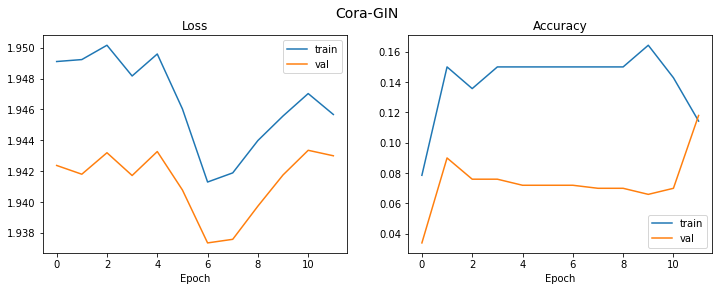

In [97]:
plt.figure(figsize=(12, 4))
plot_history(history, "Cora-GIN")


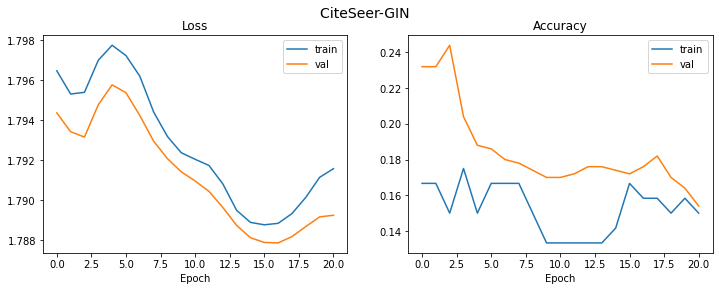

In [98]:
plt.figure(figsize=(12, 4))
plot_history(history2, "CiteSeer-GIN ")

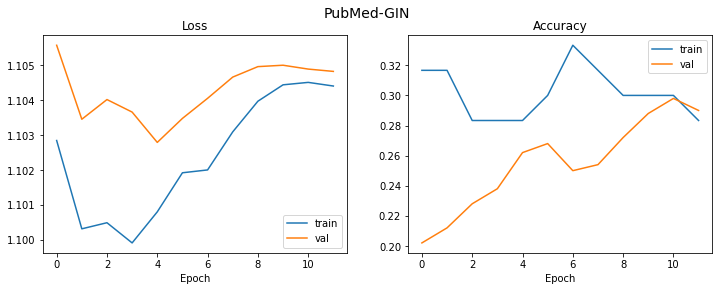

In [99]:
plt.figure(figsize=(12, 4))
plot_history(history3, "PubMed-GIN")